# Facial Anti-Spoofing using Deep Neural Network Approaches

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import recall_score

## Data Splitting

In [4]:
data_dir = '/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/preprocessed_data'
output_dir = '/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/split_data'

In [5]:
from sklearn.model_selection import train_test_split
import os
import shutil

def create_splits(data_dir=data_dir, output_dir=output_dir, split_ratio=(0.7, 0.15, 0.15), undersample = False):
    """
    Create data splits for training, validation, and testing.

    Parameters:
    - data_dir: Path to the directory containing the 'live' and 'spoof' subdirectories.
    - output_dir: Path to the directory where the splits will be saved.
    - split_ratio: A tuple indicating the split ratio for training, validation, and testing sets.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
        spoof_path = "spoof_undersampled" if undersample else "spoof"
        os.makedirs(os.path.join(output_dir, 'train', 'live'))
        os.makedirs(os.path.join(output_dir, 'train', spoof_path))
        os.makedirs(os.path.join(output_dir, 'val', 'live'))
        os.makedirs(os.path.join(output_dir, 'val', spoof_path))
        os.makedirs(os.path.join(output_dir, 'test', 'live'))
        os.makedirs(os.path.join(output_dir, 'test', spoof_path))

    for category in ['live', 'spoof']:
        files = os.listdir(os.path.join(data_dir, category))
        train_files, test_files = train_test_split(files, test_size=(1 - split_ratio[0]), random_state=42)
        val_files, test_files = train_test_split(test_files, test_size=split_ratio[2] / (split_ratio[1] + split_ratio[2]), random_state=42)

        for file in train_files:
            shutil.copy(os.path.join(data_dir, category, file), os.path.join(output_dir, 'train', category, file))
        for file in val_files:
            shutil.copy(os.path.join(data_dir, category, file), os.path.join(output_dir, 'val', category, file))
        for file in test_files:
            shutil.copy(os.path.join(data_dir, category, file), os.path.join(output_dir, 'test', category, file))

In [6]:
# WARNING: this copies all the images to a new folder so be cautious...! :(
create_splits()

## Data Augmentation (skipped but we could do this later!)

In [5]:
# augment augment augment :)

## Preparing Data Loaders

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining the basic CNN Model

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Add more layers as needed
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  
        self.fc2 = nn.Linear(512, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()

## Training

In [13]:
import numpy as np

num_epochs = 10
patience = 2 
best_val_loss = np.inf
patience_counter = 0 

criterion = nn.CrossEntropyLoss()  # should experiment with other loss functions...
optimizer = optim.Adam(model.parameters(), lr=0.001)  # experiment with learning rate and more...

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device...") 

Using cpu device...


In [15]:
import torch.nn.functional as F

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    model.eval()  
    val_running_loss = 0.0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    val_loss = val_running_loss / len(val_loader.dataset)
    val_recall = recall_score(true_labels, pred_labels, average='binary')
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Recall: {val_recall:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth') 
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/10, Training Loss: 0.1717, Validation Loss: 0.0560, Recall: 0.9905
Epoch 2/10, Training Loss: 0.0469, Validation Loss: 0.0508, Recall: 0.9958
Epoch 3/10, Training Loss: 0.0210, Validation Loss: 0.0648, Recall: 0.9966
Epoch 4/10, Training Loss: 0.0236, Validation Loss: 0.0686, Recall: 0.9894
Early stopping triggered.


## Visualizing Predictions...

### Samples selected as the first batch from the DataLoader

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

In [44]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [45]:
def show_visualizations(num_rows=3, num_cols=8):
    num_images = num_rows * num_cols
    
    fig = plt.figure(figsize=(2.5*num_cols, 2.5*num_rows)) 
    
    for idx in range(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[]) 
        imshow(images[idx])
        ax.set_title(f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}", fontsize=10)

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

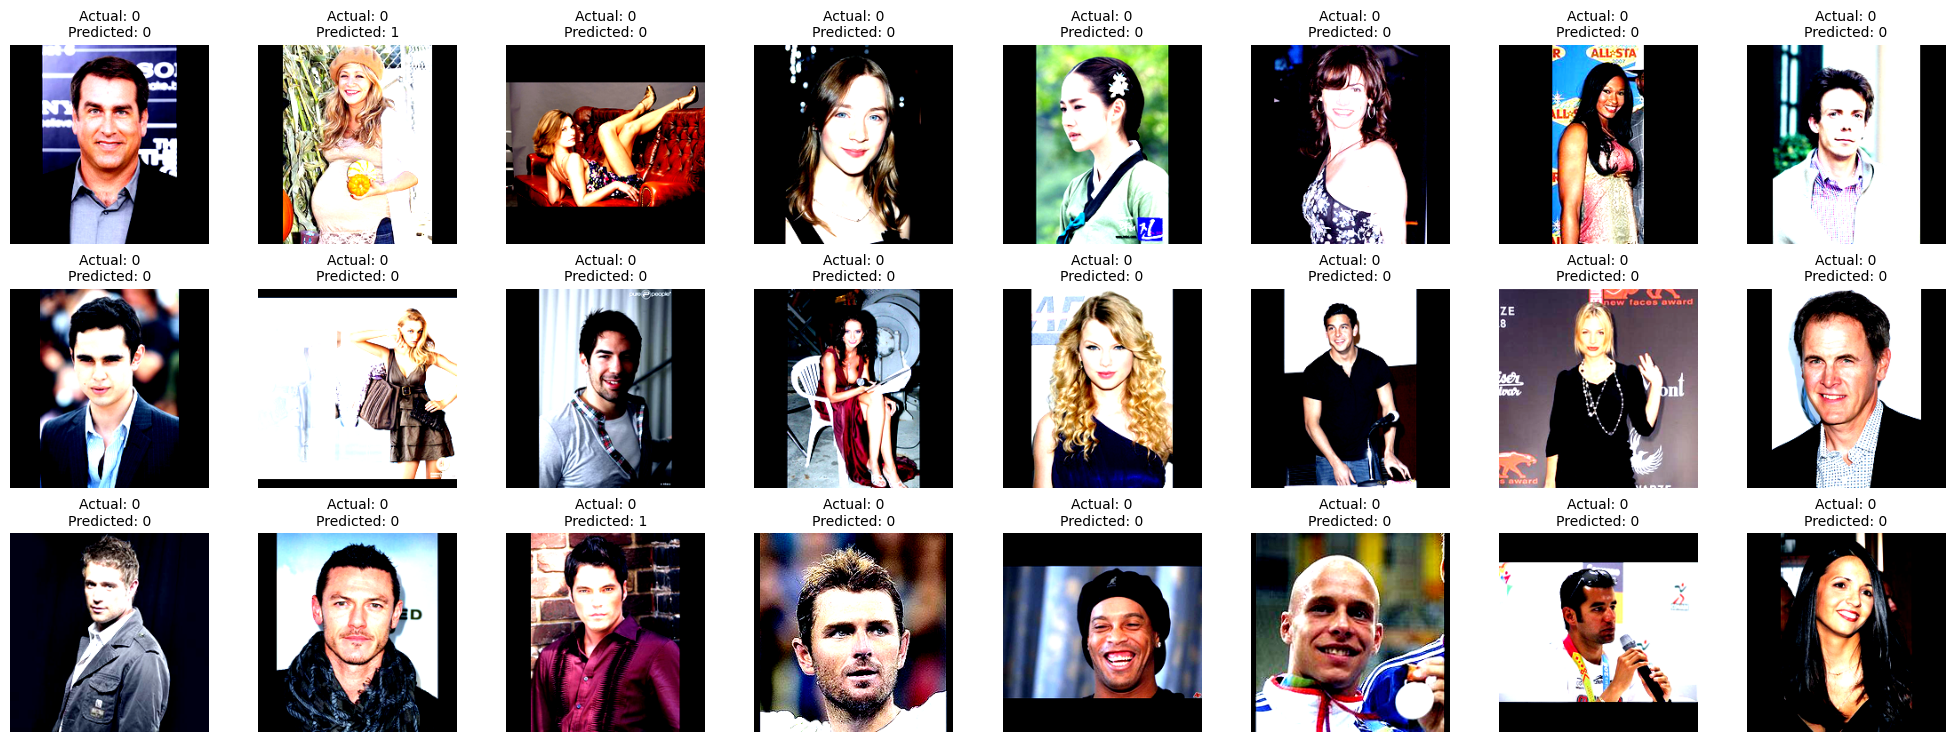

In [46]:
show_visualizations()

### Randomly sample indices without replacement

In [48]:
import torch
import numpy as np

num_samples_to_visualize = 30  
total_samples = len(val_dataset)  

random_indices = np.random.choice(total_samples, num_samples_to_visualize, replace=False)

In [49]:
from torch.utils.data import Subset

visualization_subset = Subset(val_dataset, random_indices)
visualization_loader = DataLoader(visualization_subset, batch_size=num_samples_to_visualize, shuffle=False)

In [50]:
images, labels = next(iter(visualization_loader))

model.eval()  
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

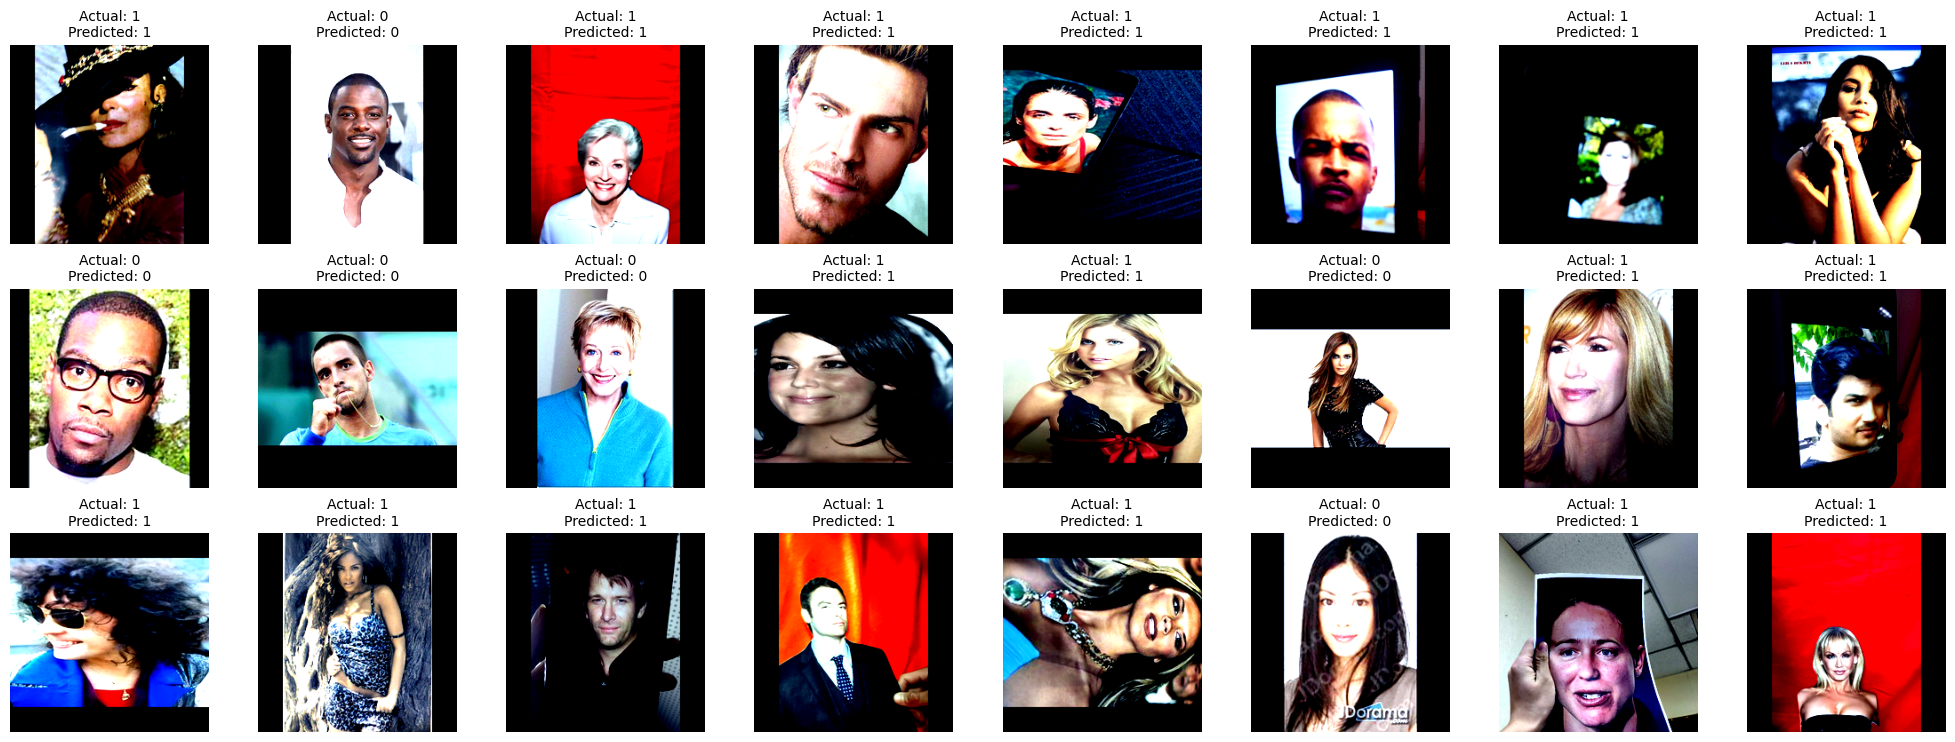

In [52]:
show_visualizations()